## Minimum code for plotting Hel2-del and Syh1-del codon pair library effects
- (Figure 4)

In [1]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(plotrix))
suppressPackageStartupMessages(library(ggh4x))
options(repr.matrix.max.rows = 20)

AMINO_ACID_CODE["*"] = "*"

barcode_reads_cutoff <- 10 # each individual barcode should have >= these many reads
n_barcodes_cutoff <- 4 # each insert should have >= this many barcodes

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘ggh4x’ was built under R version 4.2.3”


### Global plotting themes

In [2]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [3]:
if (!file.exists('../figures')){
    dir.create('../figures')}
if (!file.exists('../tables')){
    dir.create('../tables')}

## Load and combine barcode counts

In [4]:
insert_annotations = read_csv("../../8xdicodon_linkage/annotations/dicodon_yeast.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na(dicodon) %>% # drops the inserts that aren't dicodons in this case
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    select(-insert)

Rows: 6000 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_name = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 99948 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 163535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 110997 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): barcode_count, insert_num, barcode, linkage_count
dbl (1): barcode_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the colu

In [6]:
barcode_counts <- counts %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    mutate(sample_type = ifelse(str_detect(sample_type, 'reseq'), str_extract(sample_name, '(?<=_).+(?=_)'), sample_type)) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count) %>%
    group_by(genotype, sample_type, barcode_num, insert_num) %>% # combine resequenced counts together
    summarize(barcode_count = sum(barcode_count), .groups='drop')

In [7]:
barcode_counts %>%
    write_tsv("../tables/barcode_insert_counts.tsv.gz")

In [8]:
wt_barcode_counts <- read_tsv("../../wt_mrna_grna/tables/barcode_insert_counts.tsv.gz") %>%
    mutate(genotype = str_extract(sample_name, '[^_]+')) %>%
    mutate(sample_type = str_extract(sample_name, '(?<=_).+')) %>%
    select(genotype, sample_type, barcode_num, insert_num, barcode_count)

Rows: 370377 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): barcode, sample_name, linkage_ref
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Prepare data for bootstrapping: apply minimal filters and separate by strain

In [9]:
hel2_dicodons <- barcode_counts %>%
    filter(genotype == 'hel2') %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(sample_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>% # filter out inserts that don't reach barcode rep cutoff while maintaining data as individual barcodes
    ungroup() %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(n_barcodes, barcode_count)) %>%
    drop_na()

In [10]:
syh1_dicodons <- barcode_counts %>%
    filter(genotype == 'syh1') %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(sample_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>%
    ungroup() %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(n_barcodes, barcode_count)) %>%
    drop_na()

In [11]:
wt_dicodons <- wt_barcode_counts %>%
    filter(genotype == 'wt') %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    group_by(sample_type, insert_num) %>%
    mutate(n_barcodes = n()) %>%
    filter(n_barcodes >= n_barcodes_cutoff) %>%
    ungroup() %>%
    inner_join(insert_annotations, by='insert_num') %>%
    select(-aa1, -aa2, -codon1, -codon2) %>%
    pivot_wider(names_from='sample_type', values_from=c(n_barcodes, barcode_count)) %>%
    drop_na()

In [12]:
dicodons_with_barcode_cutoffs <- bind_rows(hel2_dicodons, syh1_dicodons, wt_dicodons) %>%
  left_join(insert_annotations, by=c('insert_num', 'dicodon', 'diaa'))

### Bootstrap by dipeptide

In [13]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$barcode_count_mrna)) - log2(sum(d$barcode_count_gdna))
}

wt_boot_diaa <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'wt') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='WT')

hel2_boot_diaa <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'hel2') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Hel2-del')

syh1_boot_diaa <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'syh1') %>%
  group_by(diaa) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Syh1-del')

bootstrap_diaa <- bind_rows(wt_boot_diaa, hel2_boot_diaa, syh1_boot_diaa)

In [14]:
dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'wt') %>%
  group_by(diaa) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-diaa, -n_barc)

dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'hel2') %>%
  group_by(diaa) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-diaa, -n_barc)

dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'syh1') %>%
  group_by(diaa) %>%
  summarize(n_barc = n()) %>%
  mutate(avg = mean(n_barc), med = median(n_barc)) %>%
  slice(1) %>%
  select(-diaa, -n_barc)

avg,med
<dbl>,<int>
210.1504,148


avg,med
<dbl>,<dbl>
132.566,92


avg,med
<dbl>,<int>
154.0405,104


### Correlate between strains

In [15]:
sd_outliers <- bootstrap_diaa %>%
    group_by(genotype) %>%
    mutate(iqr = IQR(lfc_sd)) %>%
    mutate(q3 = quantile(lfc_sd, c(0.75))) %>%
    slice(1) %>%
    mutate(outlier = q3 + (iqr*1.5)) %>%
    select(genotype, iqr, outlier)

In [16]:
hel2_out_sd <- sd_outliers$outlier[[1]] + 0.05 # relax the sd filter a bit
syh1_out_sd <- sd_outliers$outlier[[2]] + 0.05
wt_out_sd <- sd_outliers$outlier[[3]] + 0.05

In [17]:
avg_data <- bootstrap_diaa %>%
    pivot_wider(names_from=genotype, values_from=c(lfc, lfc_med, lfc_sd))

res <- lm(avg_data$lfc_med_WT ~ avg_data$`lfc_med_Hel2-del`)

idx <- rstandard(res) %>%
    enframe() %>%
    filter(value <= -2) %>%
    dplyr::pull(as.numeric(name))

residuals <- rstandard(res) %>%
    enframe() %>%
    dplyr::rename('x1'='name') %>%
    mutate(x1 = as.numeric(x1))

plot_data <- avg_data %>%
    mutate(x1 = seq(1,dplyr::n(),1)) %>%
    left_join(residuals, by='x1') %>%
    mutate(label = ifelse((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Hel2-del` <= hel2_out_sd) & (x1 %in% idx), 'high_residual', 'as_predicted')) %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Hel2-del` <= hel2_out_sd))
    # mutate(label = ifelse(x1 %in% idx, 'high_residual', 'as_predicted'))

label_df <- plot_data %>%
    filter(label=='high_residual') %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Hel2-del` <= hel2_out_sd))

In [18]:
plot_data %>%
    group_by(diaa) %>%
    summarize(n()) %>%
    nrow()

[1] 353

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


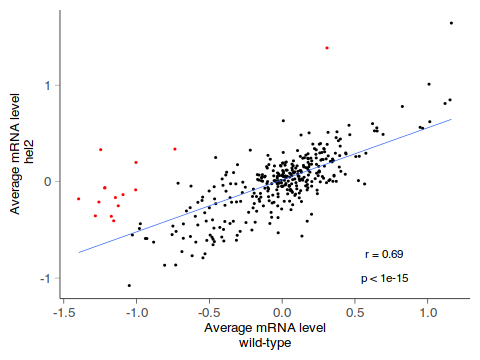

In [19]:
r = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Hel2-del`, method='pearson')$estimate
p = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Hel2-del`, method='pearson')$p.value

plot_data  %>%
    ggplot(aes(x=lfc_med_WT, y=`lfc_med_Hel2-del`)) +
    geom_point(size=0.2, aes(color=label)) +
    geom_smooth(method=lm, se=FALSE, size=0.2) +
    annotate('text', x=0.7, y=-0.75, label=str_c('r = ', round(r,2)), size=7/.pt) +
    annotate('text', x=0.7, y=-1.0, label='p < 1e-15', size=7/.pt) +
    # geom_text_repel(data=label_df, mapping=aes(x=lfc_med_WT, y=`lfc_med_Hel2-del`, label=diaa), max.overlaps=50, size=3/.pt, segment.size=0.1) +
    theme +
    theme(axis.ticks.y=element_line(size=0.1),
        ) +
    scale_color_manual(values=c('as_predicted'='black', 'high_residual'='red')) +
    guides(color='none') +
    labs(x='Average mRNA level\nwild-type', y='Average mRNA level\n hel2')

ggsave("../figures/fig4_wt_hel2_diaa_corr.pdf", width=1.9, height=1.7, units='in', dpi=300)

In [20]:
res <- lm(avg_data$lfc_med_WT ~ avg_data$`lfc_med_Syh1-del`)

idx <- rstandard(res) %>%
    enframe() %>%
    filter(value <= -2) %>%
    dplyr::pull(as.numeric(name))

residuals <- rstandard(res) %>%
    enframe() %>%
    dplyr::rename('x1'='name') %>%
    mutate(x1 = as.numeric(x1))

plot_data <- avg_data %>%
    mutate(x1 = seq(1,dplyr::n(),1)) %>%
    left_join(residuals, by='x1') %>%
    mutate(label = ifelse((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Syh1-del` <= syh1_out_sd) & (x1 %in% idx), 'high_residual', 'as_predicted')) %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Syh1-del` <= syh1_out_sd))

label_df <- plot_data %>%
    filter(label=='high_residual') %>%
    filter((lfc_sd_WT <= wt_out_sd) & (`lfc_sd_Syh1-del` <= syh1_out_sd))

In [21]:
plot_data %>%
    group_by(diaa) %>%
    summarize(n()) %>%
    nrow()

[1] 355

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


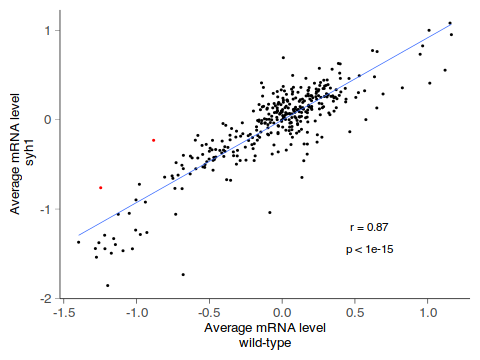

In [22]:
r = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Syh1-del`, method='pearson')$estimate
p = cor.test(plot_data$lfc_med_WT, plot_data$`lfc_med_Syh1-del`, method='pearson')$p.value

plot_data  %>%
    ggplot(aes(x=lfc_med_WT, y=`lfc_med_Syh1-del`)) +
    geom_point(size=0.2, aes(color=label)) +
    geom_smooth(method=lm, se=FALSE, size=0.2) +
    annotate('text', x=0.6, y=-1.20, label=str_c('r = ', round(r, 2)), size=7/.pt) +
    annotate('text', x=0.6, y=-1.45, label='p < 1e-15', size=7/.pt) +
    theme +
    theme(axis.ticks.y=element_line(size=0.1),
        ) +
    scale_color_manual(values=c('as_predicted'='black', 'high_residual'='red')) +
    # geom_text(data = label_df, aes(x=lfc_med_WT, y=`lfc_med_Syh1-del`, label=diaa), color='black', size=5/.pt) + 
    guides(color='none') +
    labs(x='Average mRNA level\nwild-type', y='Average mRNA level\n syh1')

ggsave("../figures/fig4_wt_syh1_diaa_corr.pdf", width=1.9, height=1.7, units='in', dpi=300)

### Pull out the dipeptides with the greatest bootstrapped delta where WT is destabilized

In [23]:
destab_wt <- read_csv("../../wt_mrna_grna/tables/destabilized_wt.csv") %>%
    filter(Frame == "In-frame") %>%
    dplyr::pull(match_diaa)

Rows: 38 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Frame, match_diaa
dbl (4): lfc, lfc_sd, var, lfc_med

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


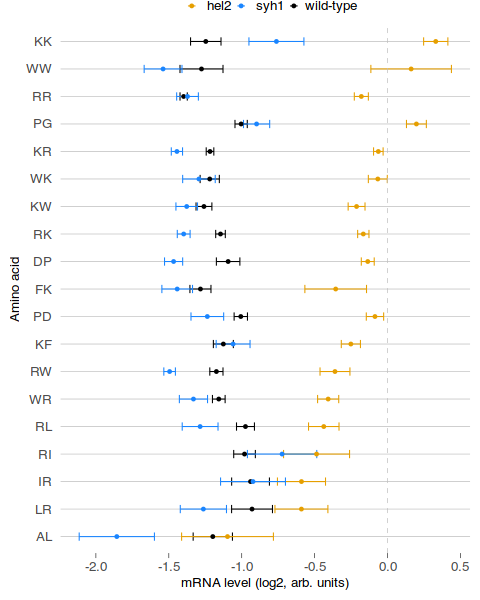

In [24]:
options(repr.plot.width = 4, repr.plot.height = 5)

bootstrap_diaa %>%
  filter(diaa %in% c(destab_wt)) %>%
  filter(!str_detect(diaa, '\\*')) %>%
  filter(diaa != 'YK') %>%
  group_by(diaa) %>%
  mutate(order = lfc_med[genotype == 'Hel2-del'] - lfc_med[genotype == 'WT']) %>%
  mutate(genotype = case_when(genotype == 'WT' ~ 'wild-type', genotype == 'Hel2-del' ~ ' hel2', genotype == 'Syh1-del' ~ ' syh1')) %>%
  ungroup() %>%
  mutate(diaa = fct_reorder(diaa, order)) %>%
  ggplot(aes(x = lfc_med, y = diaa,
             xmin = lfc_med - lfc_sd, xmax = lfc_med + lfc_sd,
             color=genotype)) +
  geom_errorbar(width=0.3, size=0.3) +
  geom_point(size=0.7) +
  scale_color_manual(values=c('wild-type'='black', ' hel2'='#E69F00', ' syh1' = '#1A85FF')) +
  # scale_x_continuous(breaks=seq(-2.5,1,0.5), limits=c(-2.5,0.5)) +
  theme + 
  theme(legend.position = "top",
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        ) +
  labs(x = "mRNA level (log2, arb. units)", y = "Amino acid", color='') +
  geom_vline(xintercept=0, color='grey', size=0.2, linetype=2)

ggsave("../figures/fig4_destab_diaa_in_wt.pdf", width=2.4, height=3.15)

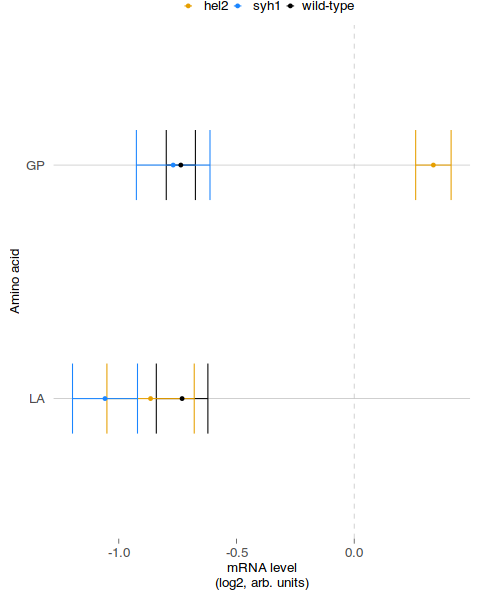

In [25]:
options(repr.plot.width = 4, repr.plot.height = 5)

bootstrap_diaa %>%
  filter(diaa %in% c('GP', 'LA')) %>%
  filter(!str_detect(diaa, '\\*')) %>%
  group_by(diaa) %>%
  mutate(order = lfc_med[genotype == 'Hel2-del'] - lfc_med[genotype == 'WT']) %>%
  mutate(genotype = case_when(genotype == 'WT' ~ 'wild-type', genotype == 'Hel2-del' ~ ' hel2', genotype == 'Syh1-del' ~ ' syh1')) %>%
  ungroup() %>%
  mutate(diaa = fct_reorder(diaa, order)) %>%
  ggplot(aes(x = lfc_med, y = diaa,
             xmin = lfc_med - lfc_sd, xmax = lfc_med + lfc_sd,
             color=genotype)) +
  geom_errorbar(width=0.3, size=0.3) +
  geom_point(size=0.7) +
  scale_color_manual(values=c('wild-type'='black', ' hel2'='#E69F00', ' syh1' = '#1A85FF')) +
  theme + 
  theme(legend.position = "top",
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        ) +
  labs(x = "mRNA level\n(log2, arb. units)", y = "Amino acid", color='') +
  geom_vline(xintercept=0, color='grey', size=0.2, linetype=2)

ggsave("../figures/sfig_destab_diaa_in_wt_gp.pdf",width=1.9, height=1.35)

## Look at codon level effects

In [26]:
calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$barcode_count_mrna)) - log2(sum(d$barcode_count_gdna))
}

wt_boot_dicodon <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'wt') %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='WT')

hel2_boot_dicodon <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'hel2') %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Hel2-del')

syh1_boot_dicodon <- dicodons_with_barcode_cutoffs %>%
  filter(genotype == 'syh1') %>%
  group_by(dicodon) %>%
  nest() %>%
  mutate(lfc_boot = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=100)$t)) %>%
  select(-data) %>%
  mutate(lfc = map_dbl(lfc_boot, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc_boot, sd)) %>%
  select(-lfc_boot) %>%
  ungroup() %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  mutate(genotype='Syh1-del')

bootstrap_dicodon <- bind_rows(wt_boot_dicodon, hel2_boot_dicodon, syh1_boot_dicodon)

In [27]:
select <- insert_annotations %>%
    filter(str_detect(aa1, '[M|L|I|V|F|Y|W]') & str_detect(aa2, '[M|L|I|V|F|Y|W]')) %>%
    dplyr::pull(insert_num) %>%
    unique()

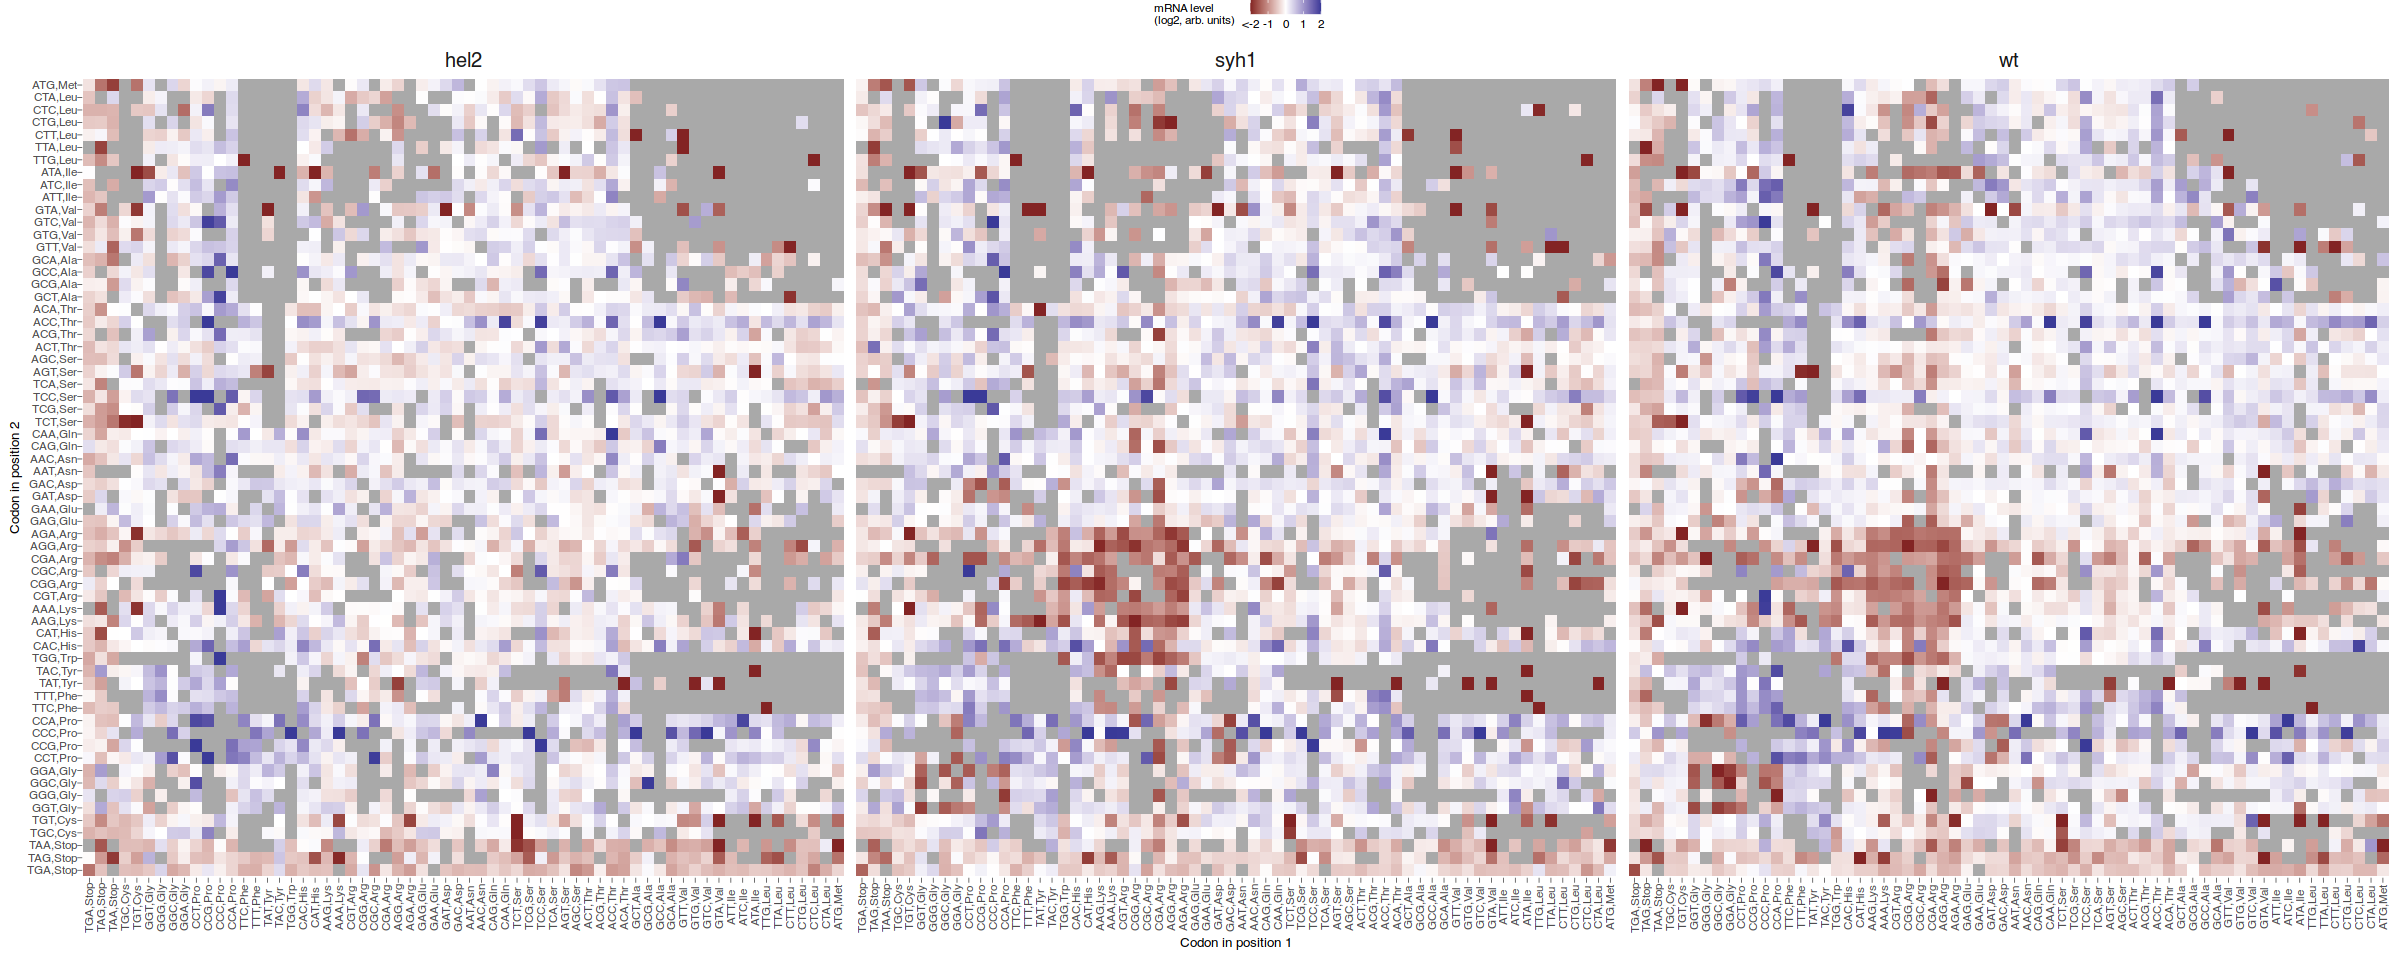

In [28]:
options(repr.plot.width = 20, repr.plot.height = 8)

AMINO_ACID_CODE['*'] ='Stop'
codon_reorder_list <- c('ATG,Met','CTA,Leu','CTC,Leu','CTG,Leu','CTT,Leu','TTA,Leu','TTG,Leu','ATA,Ile','ATC,Ile','ATT,Ile','GTA,Val','GTC,Val','GTG,Val','GTT,Val','GCA,Ala','GCC,Ala','GCG,Ala','GCT,Ala','ACA,Thr','ACC,Thr','ACG,Thr','ACT,Thr','AGC,Ser','AGT,Ser','TCA,Ser','TCC,Ser','TCG,Ser','TCT,Ser','CAA,Gln','CAG,Gln','AAC,Asn','AAT,Asn','GAC,Asp','GAT,Asp','GAA,Glu','GAG,Glu','AGA,Arg','AGG,Arg','CGA,Arg','CGC,Arg','CGG,Arg','CGT,Arg','AAA,Lys','AAG,Lys','CAT,His','CAC,His','TGG,Trp','TAC,Tyr','TAT,Tyr','TTT,Phe','TTC,Phe','CCA,Pro','CCC,Pro','CCG,Pro','CCT,Pro','GGA,Gly','GGC,Gly','GGG,Gly','GGT,Gly','TGT,Cys','TGC,Cys','TAA,Stop','TAG,Stop','TGA,Stop')
aa_order <- c('Arg', 'Stop', 'Trp', 'Lys', 'Gly', 'Cys', 'Val', 'Glu', 'Gln', 'Asp', 'Ser', 'Met', 'Ala', 'Leu', 'Ile', 'Asn', 'Tyr', 'His', 'Thr', 'Phe', 'Pro')

dicodons_with_barcode_cutoffs %>%
  group_by(genotype, insert_num) %>%
  summarize(lfc = log2(sum(barcode_count_mrna)/sum(barcode_count_gdna)), .groups='drop') %>%
  group_by(genotype) %>%
  mutate(lfc_med = lfc - median(lfc)) %>%
  ungroup() %>%
  left_join(insert_annotations, by='insert_num') %>%
  select(genotype, codon1, codon2, lfc_med) %>% 
  complete(genotype, codon1, codon2) %>%
  mutate(codon1 = factor(str_c(codon1, ',', AMINO_ACID_CODE[GENETIC_CODE[codon1]]), levels=rev(codon_reorder_list))) %>% 
  mutate(codon2 = factor(str_c(codon2, ',', AMINO_ACID_CODE[GENETIC_CODE[codon2]]), levels=rev(codon_reorder_list))) %>%
  mutate(scaled_lfc = ifelse(lfc_med >= -2 & lfc_med <= 2, lfc_med, ifelse(lfc_med > 2, 2, ifelse(lfc_med < -2, -2, NA)))) %>%
  ggplot(aes(x = codon1, y = codon2, fill = scaled_lfc)) +
  geom_tile() +
  facet_wrap(~genotype) +
  scale_fill_gradient2(na.value='dark grey', labels = rev(c('2', '1', '0', '-1', '<-2'))) +
  theme +
  theme(axis.text.x = element_text(angle = 90, vjust=0.5, margin = margin(r = 0), size=7),
        axis.text.y = element_text(margin = margin(r = 0), size=7),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        legend.key.height = unit(3, 'mm'),
        legend.key.width = unit(3, 'mm'),
        legend.text = element_text(size=7),
        legend.title = element_text(size=7),
        legend.box.margin=margin(-12,-12,-12,-12),
        legend.position='top',
        legend.justification='center',
        ) +
  guides(fill = guide_colourbar(title.position="left", title.justification='left')) +
  labs(fill = "mRNA level\n(log2, arb. units)", x = "Codon in position 1", y = "Codon in position 2")

ggsave("../figures/all_strains.png", width=20, height=10)

## Look at Grayhack/Fields inhibitory codon pairs

https://www.sciencedirect.com/science/article/pii/S0092867416306742#fig2

In [29]:
inhibitory_pairs <- c('AGGCGA', 'AGGCGG', 'ATACGA', 'ATACGG', 'CGAATA', 'CGACCG', 'CGACGA', 'CGACGG', 'CGACTG', 'CGAGCG', 'CTCCCG', 'CTGATA', 'CTGCCG', 'CTGCGA', 'GTACCG', 'GTACGA', 'GTGCGA')
inhibitory_diaa <- c('RR', 'IR', 'RI', 'RP', 'RL', 'RA', 'LP', 'LI', 'LR', 'VP', 'VR')

In [30]:
plot_data <- bootstrap_dicodon %>%
  mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-\ninhibitory')) %>%
  left_join(insert_annotations, by='dicodon') %>%
  filter(diaa %in% inhibitory_diaa) %>%
  mutate(diaa1 = str_c(dicodon, ',', diaa)) %>%
  mutate(genotype = case_when(genotype == 'WT' ~ 'wild-type', genotype == 'Hel2-del' ~ 'hel2 ', genotype == 'Syh1-del' ~ 'syh1 '))

In [31]:
order <- plot_data %>%
  complete(genotype, diaa1) %>%
  mutate(diaa = ifelse(is.na(diaa), str_sub(diaa1, 8,9), diaa)) %>%
  filter(genotype == 'wild-type') %>%
  arrange(diaa) %>%
  dplyr::pull(diaa1)

In [32]:
a <- plot_data %>%
    complete(genotype, diaa1) %>%
    mutate(diaa = ifelse(is.na(diaa), str_sub(diaa1, 8,9), diaa)) %>%
    mutate(dicodon = ifelse(is.na(dicodon), str_sub(diaa1, 1,6), dicodon)) %>%
    filter(genotype == 'wild-type') %>%
    arrange(factor(diaa1, levels=order)) %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    mutate(a = ifelse(grp == 'inhibitory', 'red', 'black')) %>%
    dplyr::pull(a)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 94 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 94 rows containing missing values (`geom_point()`).”


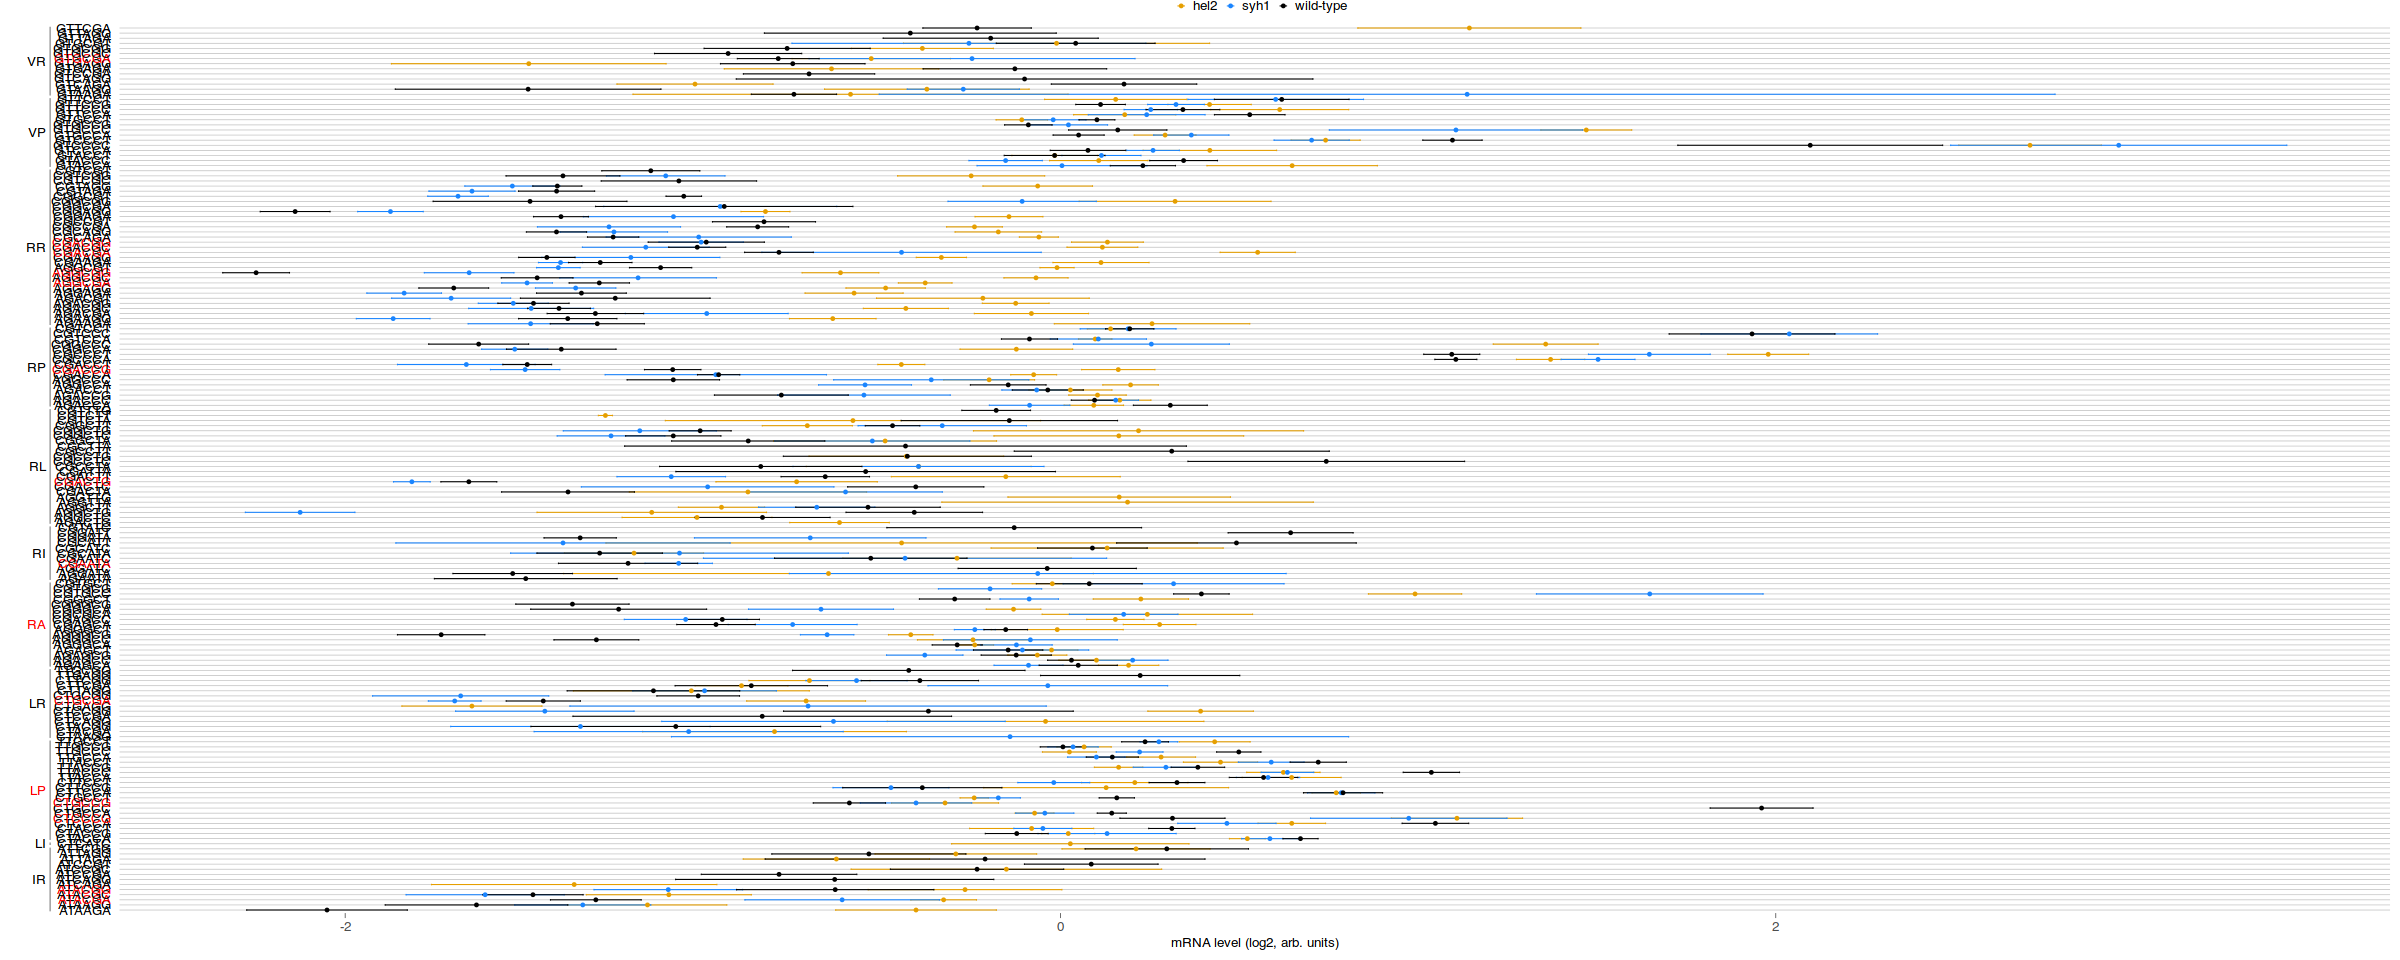

In [33]:
plot_data %>%
    complete(genotype, diaa1) %>%
    mutate(diaa = ifelse(is.na(diaa), str_sub(diaa1, 8,9), diaa)) %>%
    mutate(dicodon = ifelse(is.na(dicodon), str_sub(diaa1, 1,6), dicodon)) %>%
    mutate(diaa1 = factor(diaa1, levels=order)) %>%
    ggplot() +
  aes(y=diaa1, x=lfc_med, xmin=lfc_med-lfc_sd, xmax=lfc_med+lfc_sd, color=genotype) +
  geom_errorbar(width=0.3, size=0.3) +
  geom_point(size=0.7) +
  scale_y_discrete(guide = guide_axis_nested(delim = ",")) +
  theme + 
  scale_color_manual(values=c('wild-type'='black', 'hel2 '='#E69F00', 'syh1 ' = '#1A85FF')) +
  theme(legend.position = "top",
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        ggh4x.axis.nestline = element_line(linewidth = 0.2),
        ggh4x.axis.nesttext.y = element_text(),
        axis.text.y = element_text(colour = a)
        ) +
  labs(x = "mRNA level (log2, arb. units)", y = "", color='')

ggsave("../figures/all_inhibitory_noninhibitory_pairs.pdf", width=4, height=15)

In [34]:
plot_data <- dicodons_with_barcode_cutoffs %>% # already filtered >= 10 reads/barcode and >=4 barcodes/insert
    group_by(genotype, insert_num, dicodon, diaa) %>%
    summarize(mrna = sum(barcode_count_mrna), grna = sum(barcode_count_gdna), .groups='drop') %>%
    filter(mrna >= 100, grna >= 100) %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    mutate(lfc = log2(mrna/grna)) %>%
    group_by(genotype) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    ungroup() %>%
    filter(diaa %in% inhibitory_diaa) %>%
    select(genotype, dicodon, diaa, grp, lfc_med) %>%
    mutate(diaa1 = str_c(dicodon, ',', diaa))

In [35]:
order <- plot_data %>%
  complete(genotype, diaa1) %>%
  mutate(diaa = ifelse(is.na(diaa), str_sub(diaa1, 8,9), diaa)) %>%
  filter(genotype == 'wt') %>%
  arrange(diaa) %>%
  dplyr::pull(diaa1)

In [36]:
a <- plot_data %>%
    complete(genotype, diaa1) %>%
    mutate(diaa = ifelse(is.na(diaa), str_sub(diaa1, 8,9), diaa)) %>%
    mutate(dicodon = ifelse(is.na(dicodon), str_sub(diaa1, 1,6), dicodon)) %>%
    filter(genotype == 'wt') %>%
    arrange(factor(diaa1, levels=order)) %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    mutate(a = ifelse(grp == 'inhibitory', 'red', 'black')) %>%
    dplyr::pull(a)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


Warning message:
“Removed 91 rows containing missing values (`geom_point()`).”


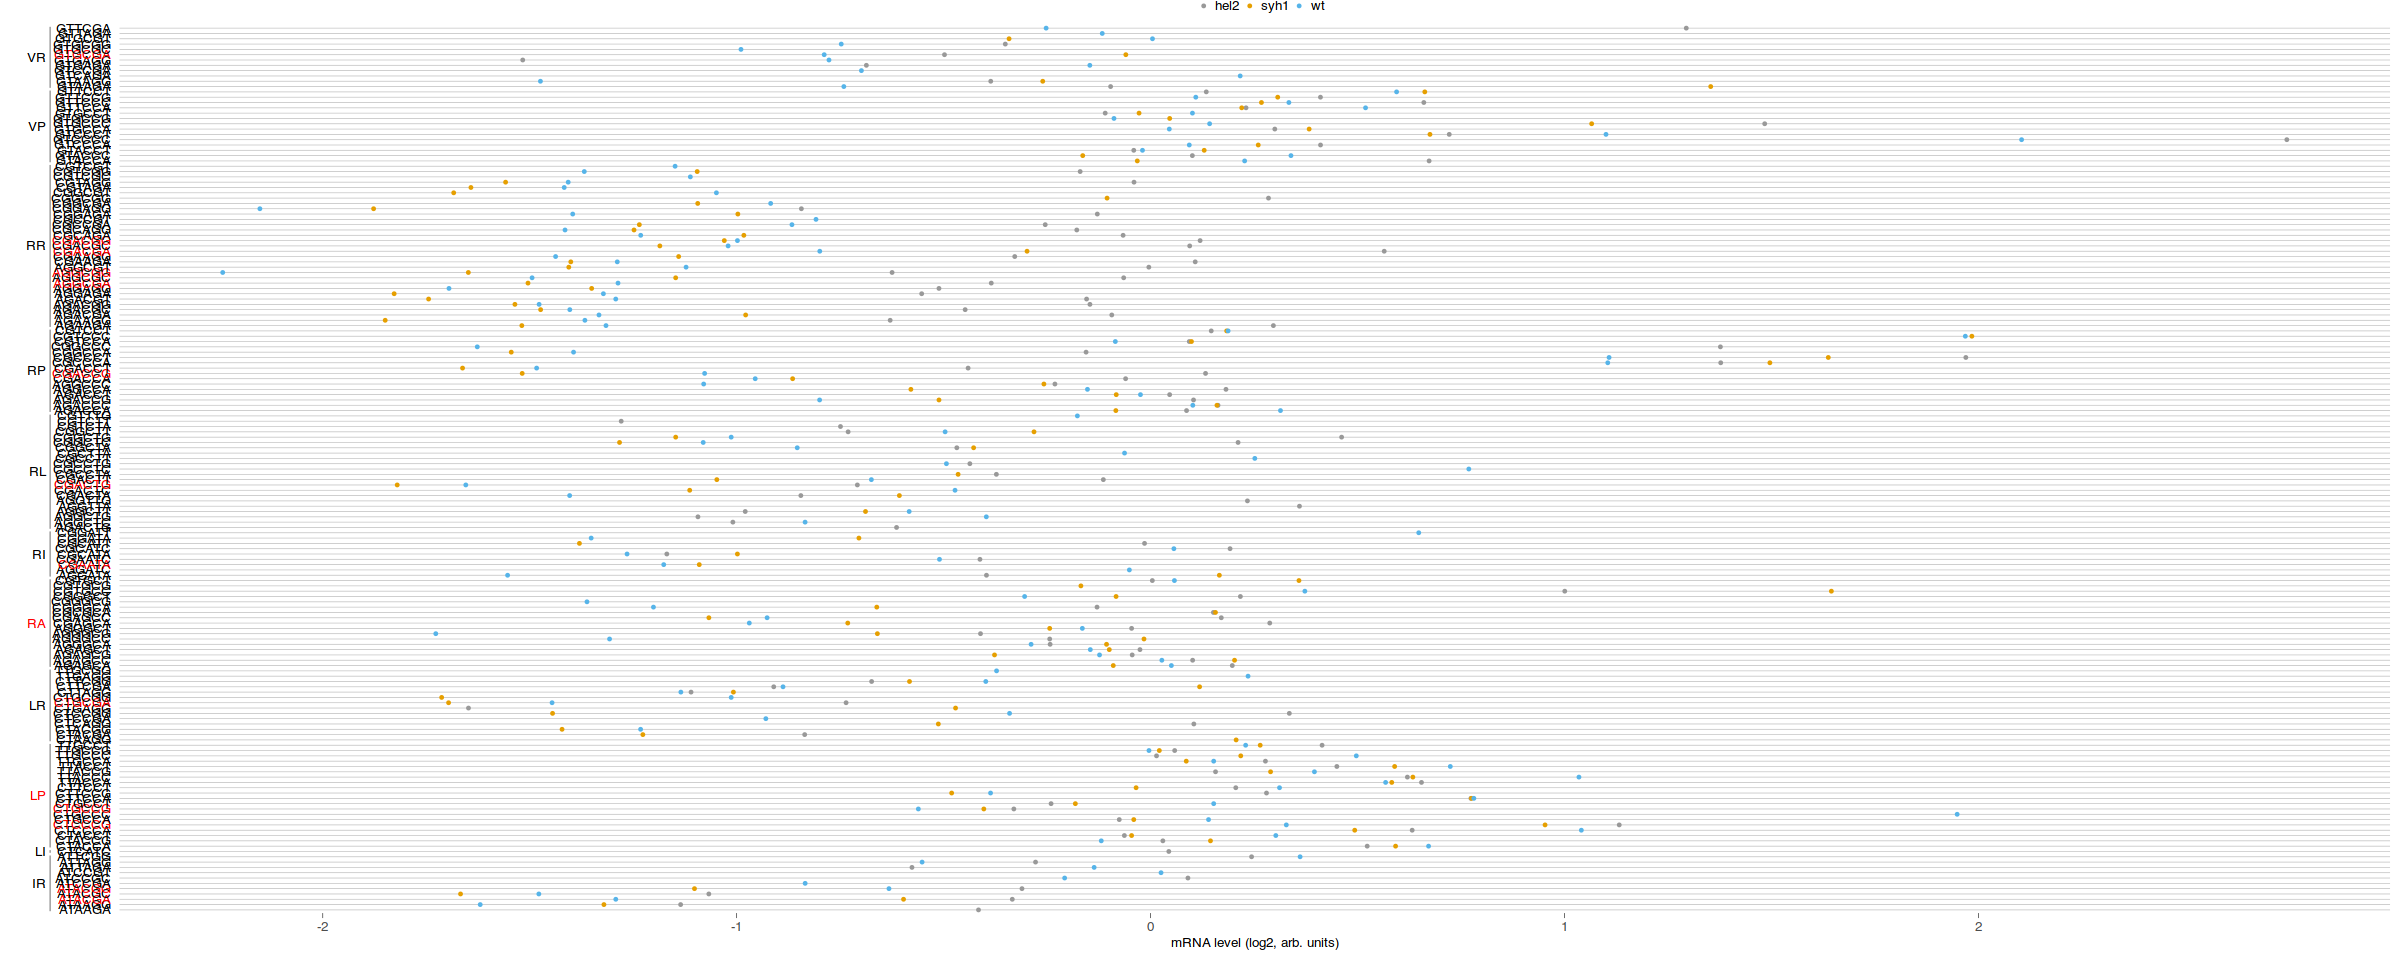

In [37]:
plot_data %>%
    complete(genotype, diaa1) %>%
    mutate(diaa = ifelse(is.na(diaa), str_sub(diaa1, 8,9), diaa)) %>%
    mutate(dicodon = ifelse(is.na(dicodon), str_sub(diaa1, 1,6), dicodon)) %>%
    mutate(diaa1 = factor(diaa1, levels=order)) %>%
    ggplot() +
  aes(y=diaa1, x=lfc_med, color=genotype) +
  geom_point(size=0.7) +
  scale_y_discrete(guide = guide_axis_nested(delim = ",")) +
  theme + 
  theme(legend.position = "top",
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        ggh4x.axis.nestline = element_line(linewidth = 0.2),
        ggh4x.axis.nesttext.y = element_text(),
        axis.text.y = element_text(colour = a)
        ) +
  labs(x = "mRNA level (log2, arb. units)", y = "", color='')

# ggsave("../figures/all_inhibitory_noninhibitory_pairs.pdf", width=4, height=15)

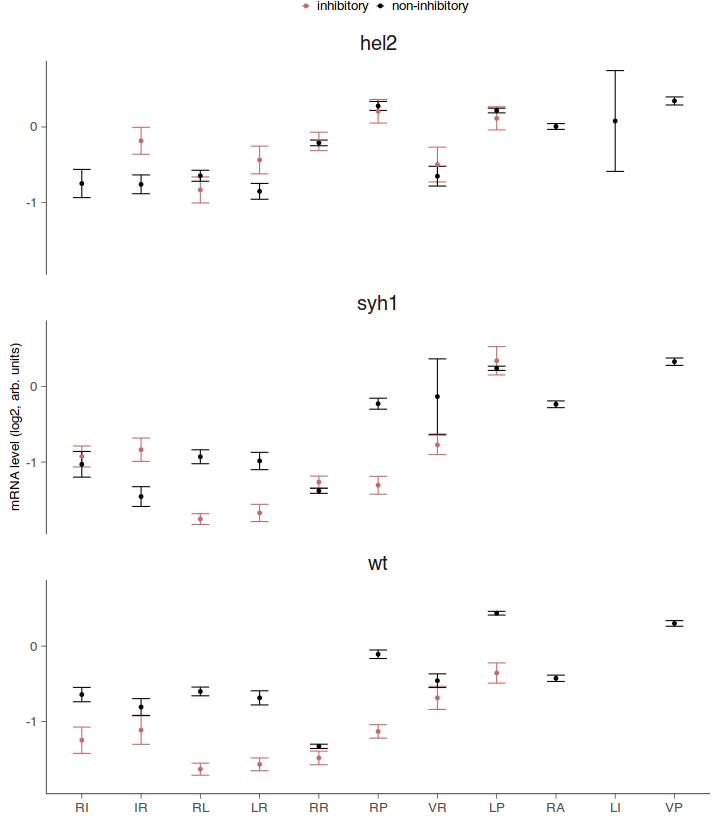

In [38]:
options(repr.plot.width = 6, repr.plot.height = 7)

order <- c('RI', 'IR', 'RL', 'LR', 'RR', 'RP', 'VR', 'LP', 'RA', 'LI', 'VP')

dicodons_with_barcode_cutoffs %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    mutate(lfc = log2(barcode_count_mrna/barcode_count_gdna)) %>%
    group_by(genotype) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    ungroup() %>%
    filter(diaa %in% inhibitory_diaa) %>%
    group_by(genotype, diaa, grp) %>%
    summarize(avg = mean(lfc_med), s = std.error(lfc_med), .groups='drop') %>%
    mutate(diaa = factor(diaa, order)) %>%
    ggplot() +
    aes(x=diaa, y=avg, ymin=avg-s, ymax=avg+s, color=grp) +
    facet_wrap(~genotype, ncol=1) +
    geom_errorbar(width=0.3, size=0.3) +
    geom_point(size=0.7) +
    scale_colour_manual(values=c('inhibitory'='#CC6666', 'non-inhibitory'='black')) +
    theme + 
    theme(legend.position = "top",
            legend.key.height = unit(2.5, 'mm'),
            legend.key.width = unit(2, 'mm'),
            legend.text = element_text(size=8),
            legend.title = element_text(size=8),
            legend.box.margin=margin(-12,-12,-12,-12),
            ) +
    labs(y = "mRNA level (log2, arb. units)", x = "", color='')

ggsave("../figures/avg_inhibitory_by_diaa.pdf", width=4.5, height=7)

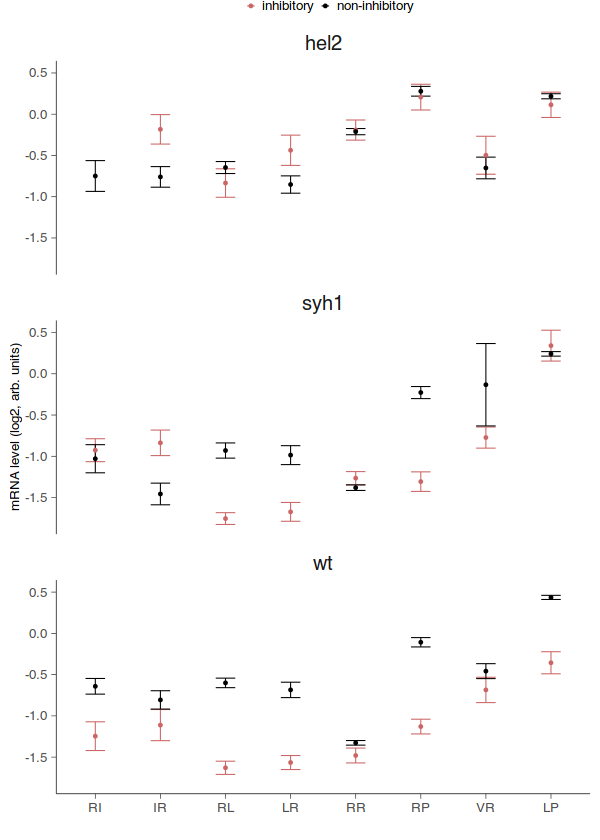

In [39]:
options(repr.plot.width = 5, repr.plot.height = 7)

order <- c('RI', 'IR', 'RL', 'LR', 'RR', 'RP', 'VR', 'LP')

dicodons_with_barcode_cutoffs %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    mutate(lfc = log2(barcode_count_mrna/barcode_count_gdna)) %>%
    group_by(genotype) %>%
    mutate(lfc_med = lfc - median(lfc)) %>%
    ungroup() %>%
    filter(diaa %in% inhibitory_diaa) %>%
    filter(!diaa %in% c('LI', 'RA', 'VP')) %>% # remove the diaa that have missing data
    group_by(genotype, diaa, grp) %>%
    summarize(avg = mean(lfc_med), s = std.error(lfc_med), .groups='drop') %>%
    mutate(diaa = factor(diaa, order)) %>%
    ggplot() +
    aes(x=diaa, y=avg, ymin=avg-s, ymax=avg+s, color=grp) +
    facet_wrap(~genotype, ncol=1) +
    geom_errorbar(width=0.3, size=0.3) +
    geom_point(size=0.7) +
    scale_colour_manual(values=c('inhibitory'='#CC6666', 'non-inhibitory'='black')) +
    theme + 
    theme(legend.position = "top",
            legend.key.height = unit(2.5, 'mm'),
            legend.key.width = unit(2, 'mm'),
            legend.text = element_text(size=8),
            legend.title = element_text(size=8),
            legend.box.margin=margin(-12,-12,-12,-12),
            ) +
    labs(y = "mRNA level (log2, arb. units)", x = "", color='')

# ggsave("../figures/avg_inhibitory_by_diaa_2.pdf", width=4.5, height=7)

Warning message:
“Removed 119 rows containing non-finite values (`stat_boxplot()`).”


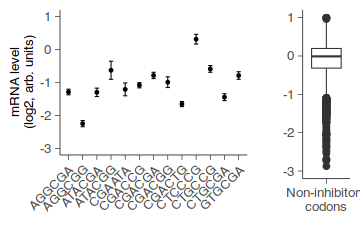

In [67]:
p1 <- bootstrap_dicodon %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    filter(genotype == 'WT') %>%
    filter(grp == 'inhibitory') %>%
    ggplot() +
    aes(x=dicodon, y=lfc_med, ymin=lfc_med-lfc_sd, ymax=lfc_med+lfc_sd) +
    geom_point(size=0.7) +
    geom_errorbar(width=0.3, size=0.3) +
    scale_y_continuous(limits=c(-3,1)) +
    theme +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
    labs(y='mRNA level\n(log2, arb. units)', x='')

options(repr.plot.width = 3, repr.plot.height = 2)

p2 <- bootstrap_dicodon %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    filter(genotype == 'WT') %>%
    filter(grp == 'non-inhibitory') %>%
    ggplot() +
    aes(x='Non-inhibitory\ncodons',y=lfc_med) +
    geom_boxplot(size=0.3) +
    scale_y_continuous(limits=c(-3,1)) +
    theme +
    labs(x='', y='')

plot <- grid.arrange(p1, p2, nrow=1, widths=c(2.5,1))

Warning message:
“Removed 119 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 119 rows containing non-finite values (`stat_boxplot()`).”


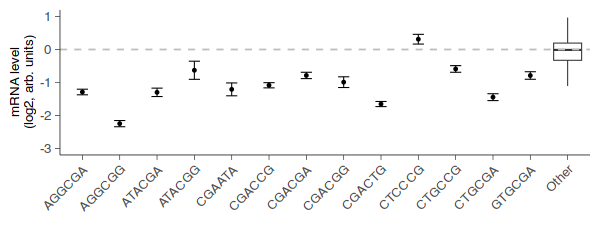

In [86]:
options(repr.plot.width = 5, repr.plot.height = 2)

plot_data <- bootstrap_dicodon %>%
    mutate(grp = ifelse(dicodon %in% inhibitory_pairs, 'inhibitory', 'non-inhibitory')) %>%
    filter(genotype == 'WT')

plot_data_2 <- plot_data %>% mutate(dicodon = 'Other')

plot_data %>%
    filter(grp == 'inhibitory') %>%
    ggplot() +
    aes(x=dicodon, y=lfc_med, ymin=lfc_med-lfc_sd, ymax=lfc_med+lfc_sd) +
    geom_point(size=0.7) +
    geom_errorbar(width=0.3, size=0.3) +
    geom_boxplot(data = plot_data_2, size=0.3, outlier.shape=NA) +
    aes(x=dicodon, y=lfc_med) +
    scale_y_continuous(limits=c(-3,1)) +
    theme +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
    labs(y='mRNA level\n(log2, arb. units)', x='') +
    geom_hline(yintercept = 0, color='grey', linetype=2)

ggsave("../figures/inhibitory_noninhib_box.pdf", width=4, height=1.8)

In [83]:
bootstrap_dicodon %>%
    dplyr::pull(lfc) %>%
    median()

[1] -0.0007225742

### A supplementary figure summarising the impact of barcodes on mRNA levels for individual codon pairs or a supplementary table showing the numbers would be helpful.

In [41]:
bootstrap_dicodon %>%
  left_join(insert_annotations, by='dicodon') %>%
  select(dicodon, diaa, lfc_med, lfc_sd, genotype) %>%
  arrange(genotype, diaa) %>%
  write_csv("../tables/supp_table.csv")